In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

In [19]:
mat_file = "../data/student-mat.csv"
por_file = "../data/student-por.csv"

mat_df = pd.read_csv(mat_file, sep=";")
por_df = pd.read_csv(por_file, sep=";")

#creating catagorical columns list and numeric columns list
cat_columns = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian',
                'schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']

num_columns = ['Medu','Fedu','traveltime','studytime','famrel','freetime','goout','Dalc','Walc','health']
cont_columns = ['age','failures','absences','G1','G2','G3']

In [20]:
# Define the preprocessor with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_columns),
        ('num', StandardScaler(), num_columns + cont_columns[:-1])
    ],
    remainder='passthrough'
)

# Function to preprocess the dataset
def preprocess_data(df):
    X = df.drop('G3', axis=1)
    y = df['G3']
    X = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, preprocessor

# Preprocess both datasets
X_mat_train, X_mat_test, y_mat_train, y_mat_test, preprocessor_mat = preprocess_data(mat_df)
X_por_train, X_por_test, y_por_train, y_por_test, preprocessor_por = preprocess_data(por_df)

In [21]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
    adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    cv_scores = cross_val_score(model, np.vstack((X_train, X_test)), np.hstack((y_train, y_test)), cv=5, scoring='r2')
    return rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, np.mean(cv_scores)

# Perform grid search for hyperparameter tuning
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    }
}

Math Results Table:
               Model      RMSE  R2 (Training)  Adjusted R2 (Training)  \
0  Linear Regression  2.378370       0.865598                0.845486   
1      Decision Tree  2.279890       0.964722                0.959443   
2      Random Forest  2.093734       0.972261                0.968110   
3            XGBoost  1.949039       0.974733                0.970952   

   R2 (Test)  Adjusted R2 (Test)  5-Fold CV Mean R2  
0   0.724134            0.418445           0.791629  
1   0.746506            0.465608           0.811852  
2   0.786212            0.549313           0.780449  
3   0.814741            0.609453           0.865342  
Portuguese Results Table:
               Model      RMSE  R2 (Training)  Adjusted R2 (Training)  \
0  Linear Regression  1.214870       0.858337                0.846160   
1      Decision Tree  1.477207       0.889331                0.879819   
2      Random Forest  1.453955       0.967731                0.964957   
3            XGBoost  1.23

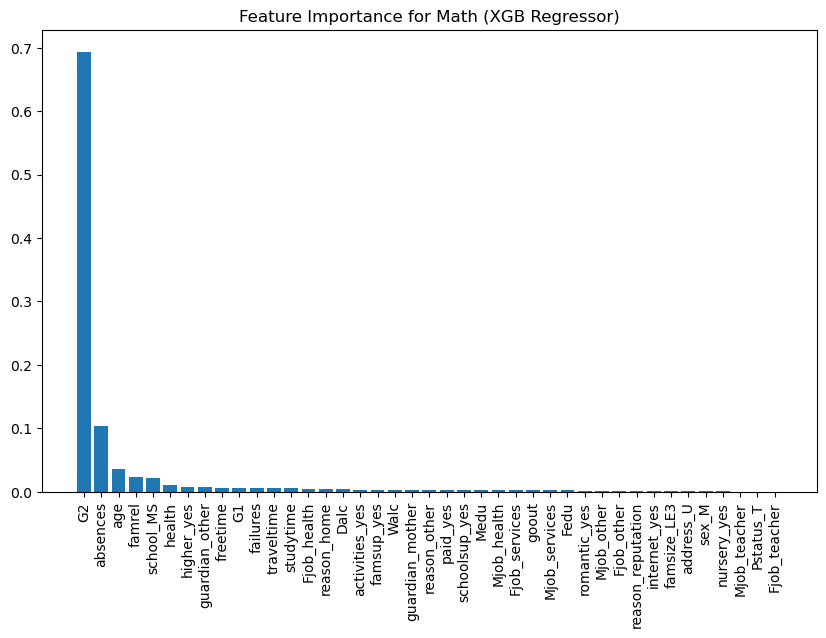

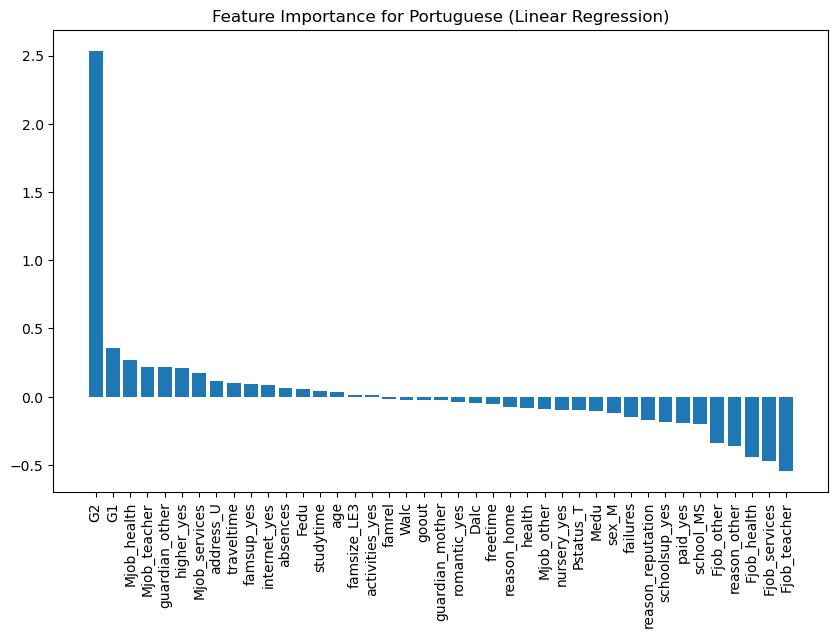

In [22]:
# Evaluate models and perform hyperparameter tuning
results_mat = {}
results_por = {}

for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(grid_search, X_mat_train, y_mat_train, X_mat_test, y_mat_test)
        results_mat[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
        
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(grid_search, X_por_train, y_por_train, X_por_test, y_por_test)
        results_por[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
    else:
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(model, X_mat_train, y_mat_train, X_mat_test, y_mat_test)
        results_mat[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
        
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(model, X_por_train, y_por_train, X_por_test, y_por_test)
        results_por[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}

# Feature importance for XGboost and LinearRegression
def plot_feature_importance(model, X_train, y_train, preprocessor, all_features, title):
    # Apply preprocessor to the training data
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the correct feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out(all_features)
    
    clean_feature_names = [name.split('__')[-1] for name in feature_names]
    
    # Fit model
    model.fit(X_train_transformed, y_train)
    
    # Get feature importances or coefficients
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = model.coef_
    else:
        raise ValueError("Model does not have feature importances or coefficients.")
    
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), np.array(clean_feature_names)[indices], rotation=90)
    plt.show()



def create_results_table(results):
    data = []
    for model_name, metrics in results.items():
        data.append([
            model_name,
            metrics['RMSE'],
            metrics['R2_train'],
            metrics['Adj_R2_train'],
            metrics['R2_test'],
            metrics['Adj_R2_test'],
            metrics['CV_mean']
        ])
    columns = ['Model', 'RMSE', 'R2 (Training)', 'Adjusted R2 (Training)', 'R2 (Test)', 'Adjusted R2 (Test)', '5-Fold CV Mean R2']
    return pd.DataFrame(data, columns=columns)

results_table_mat = create_results_table(results_mat)
results_table_por = create_results_table(results_por)

print("Math Results Table:")
print(results_table_mat)

print("Portuguese Results Table:")
print(results_table_por)

# Plot feature importance for Math and Portuguese using XGBRegressor
plot_feature_importance(XGBRegressor(), mat_df.drop('G3', axis=1), mat_df['G3'], preprocessor_mat, mat_df.drop('G3', axis=1).columns, "Feature Importance for Math (XGB Regressor)")
plot_feature_importance(LinearRegression(), por_df.drop('G3', axis=1), por_df['G3'], preprocessor_mat, por_df.drop('G3', axis=1).columns, "Feature Importance for Portuguese (Linear Regression)")

In [23]:
"""
Math Dataset
Best Model: XGBoost
RMSE: XGBoost has the lowest RMSE (1.949), indicating the smallest average prediction error.
R2 (Test): It has the highest R2 (Test) value (0.814), meaning it explains the most variance in the test data compared to other models.
Adjusted R2 (Test): It has the highest Adjusted R2 (Test) (0.609), reflecting its performance adjusted for the number of predictors.
5-Fold CV Mean R2: The highest mean R2 (0.865) in cross-validation, demonstrating consistent performance.

Portuguese Dataset
Best Model: Linear Regression
RMSE: Linear Regression has the lowest RMSE (1.214), indicating the smallest average prediction error.
R2 (Test): It has the highest R2 (Test) value (0.849), meaning it explains the most variance in the test data compared to other models.
Adjusted R2 (Test): It has the highest Adjusted R2 (Test) (0.778), reflecting its performance adjusted for the number of predictors.
5-Fold CV Mean R2: The second-highest mean R2 (0.836) in cross-validation, demonstrating consistent performance, with XGBoost having slightly higher cross-validation mean R2 but performing slightly worse on test data RMSE.
"""

'\nMath Dataset\nBest Model: XGBoost\nRMSE: XGBoost has the lowest RMSE (1.949), indicating the smallest average prediction error.\nR2 (Test): It has the highest R2 (Test) value (0.814), meaning it explains the most variance in the test data compared to other models.\nAdjusted R2 (Test): It has the highest Adjusted R2 (Test) (0.609), reflecting its performance adjusted for the number of predictors.\n5-Fold CV Mean R2: The highest mean R2 (0.865) in cross-validation, demonstrating consistent performance.\n\nPortuguese Dataset\nBest Model: Linear Regression\nRMSE: Linear Regression has the lowest RMSE (1.214), indicating the smallest average prediction error.\nR2 (Test): It has the highest R2 (Test) value (0.849), meaning it explains the most variance in the test data compared to other models.\nAdjusted R2 (Test): It has the highest Adjusted R2 (Test) (0.778), reflecting its performance adjusted for the number of predictors.\n5-Fold CV Mean R2: The second-highest mean R2 (0.836) in cross

In [24]:
"""
Educational Advice Based on Top Features

Math Education
G2 Grade: Since G2 has the highest importance, educators should focus on continuous assessment and improvement strategies throughout the term, not just before final exams. Regular feedback and targeted support can help improve final grades.
Absences: High absenteeism negatively impacts performance. Schools should implement attendance tracking systems and intervention strategies to identify and support frequently absent students.
Age: Age shows some influence, possibly reflecting maturity and readiness. Differentiated instruction strategies that cater to varying maturity levels could be beneficial.
Family Relationships (Famrel): Good family relationships are linked to better performance. Schools could involve families in educational activities and provide resources to improve home environments.
School Type (School_MS): The type of school can impact performance. Understanding and addressing specific challenges faced by students in different school types is crucial.

Portuguese Education
G2 and G1 Grades: Both G2 and G1 grades are highly important, suggesting that performance across all terms significantly impacts final outcomes. Continuous assessment and reinforcement of learning throughout the academic year are vital.
Mother's Job in Health Sector (Mjob_health) and Teacher (Mjob_teacher): These features indicate a correlation with better student performance. This might be due to better educational support at home. Schools should ensure that students without such support receive additional resources and guidance.
Guardian Other than Parent (Guardian_other): Students with guardians other than parents might face unique challenges. Schools should provide additional counseling and support services for these students.
Higher Education Aspirations (higher_yes): Encouraging students to aim for higher education can positively impact their performance. Schools should promote the benefits of higher education and provide information and support to pursue it.
Travel Time (traveltime): Longer travel times can negatively impact student performance. Schools should consider solutions to minimize travel time or provide additional support for students with long commutes.
"""

"\nEducational Advice Based on Top Features\n\nMath Education\nG2 Grade: Since G2 has the highest importance, educators should focus on continuous assessment and improvement strategies throughout the term, not just before final exams. Regular feedback and targeted support can help improve final grades.\nAbsences: High absenteeism negatively impacts performance. Schools should implement attendance tracking systems and intervention strategies to identify and support frequently absent students.\nAge: Age shows some influence, possibly reflecting maturity and readiness. Differentiated instruction strategies that cater to varying maturity levels could be beneficial.\nFamily Relationships (Famrel): Good family relationships are linked to better performance. Schools could involve families in educational activities and provide resources to improve home environments.\nSchool Type (School_MS): The type of school can impact performance. Understanding and addressing specific challenges faced by st